In [102]:
%load_ext autoreload
%autoreload 2

from collections import Counter
from inspect import signature
import math
import re
import string

import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve,
                             average_precision_score)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL) # surpress base64 can't decode character message

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Naive Bayes

Naive Baeyes is a simple but efficient [probabilistic classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) (e.g. spam claissification of email). It is simple to implement and understand since it's based on counting things. It is based on applying bayes theorem, with strong independence assumptions between the features  (hence "naive").



##### We'll build 4 models. Half using a bag of words representation, the other using TFIDF. We'll use these inputs for a naive bayes scikit implementation, and our own implementation.

---

**load the data**

In [17]:
sample_submission = pd.read_csv("../data/sample_submission.csv")
test_df = pd.read_csv("../data/test.csv")
train_df = pd.read_csv("../data/train.csv")

#### Clean the text

In [24]:
table = str.maketrans('', '', string.punctuation)
stop_words = stopwords.words('english')
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
porter = PorterStemmer()


emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

def clean_corpus(tweets):
    tokens = [" ".join(tknzr.tokenize(x)) for x in tweets]

    stripped = [w.translate(table).lower() for w in tokens]

    no_urls = [re.sub(r"http\S+", "", x) for x in stripped]

    no_html = [re.sub(r'<.*?>', "", x) for x in no_urls]

    no_emoji = [emoji_pattern.sub("", x) for x in no_html]

    stopped = [[w for w in sent.split() if not w in stop_words] for sent in no_emoji]

    stemmed = [[porter.stem(word) for word in tokens] for tokens in stopped]

    return [" ".join(words) for words in stemmed]

train_corpus = clean_corpus(train_df["text"].values)
test_corpus = clean_corpus(test_df["text"].values)
corpus = train_corpus + test_corpus

In [133]:
training_size=len(train_corpus)
test_portion=.1
# get the split point, that is the number of samples that will go into the test set
split = int(test_portion * training_size)
X_train = train_corpus[split:]
X_test = train_corpus[:split]
y_train = train_df["target"].iloc[split:].to_list()
y_test = train_df["target"].iloc[:split].to_list()

---

### Model with Bag of Words text representation

We must feed numeric data to our model, not text data. The text messages can be represented in different ways. The simplest is a bag of words, which is a frequency of the word (# of occurrences of word in dataset / total # words in dataset). Another is a TF-IDF representationm which reflects the importance of the word.

**create bag of words**

In [134]:
count_vector = CountVectorizer(stop_words='english', lowercase=True)
train_data = count_vector.fit_transform(X_train)
test_data = count_vector.transform(X_test)

**model**

In [41]:
naive_bayes = MultinomialNB()
naive_bayes.fit(train_data, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [42]:
predictions = naive_bayes.predict(test_data)

In [177]:
print(f'Accuracy score: {accuracy_score(predictions, y_test):.2f}' )
print(f'Precision score: {precision_score(predictions, y_test):.2f}')
print(f'Recall score: {recall_score(predictions, y_test):.2f}')
print(f'F1 score: {f1_score(predictions, y_test):.2f}')

Accuracy score: 0.77
Precision score: 0.63
Recall score: 0.78
F1 score: 0.70


In [44]:
confusion_matrix(y_test, predictions)

array([[366, 113],
       [ 81, 201]])

The model does a better job picking correctly true disaster tweets than it does understanding that non-disaster tweets are in fact so.

In [52]:
def plot_confusion_matrix(y_test, predictions):
    labels = [0, 1]
    cm = confusion_matrix(y_test, predictions, labels)

    labels = ["disaster", "not disaster"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

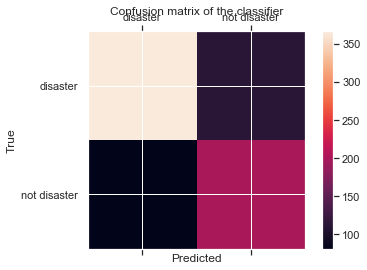

In [53]:
plot_confusion_matrix(y_test, predictions)

The model It also makes more mistakes by classifying disaster tweets as non-disaster

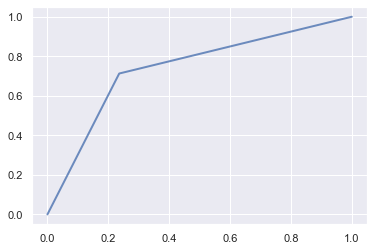

In [55]:
fpr, tpr, thresholds = roc_curve(np.array(y_test), predictions, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f)' % (roc_auc),
         lw=2, alpha=.8)

After about 65% True positive rate the model starts making a lot more false positive classifications for each increament in correct positive classification

In [56]:
precision, recall, _ = precision_recall_curve(y_test, predictions)

In [57]:
average_precision = average_precision_score(y_test, predictions)

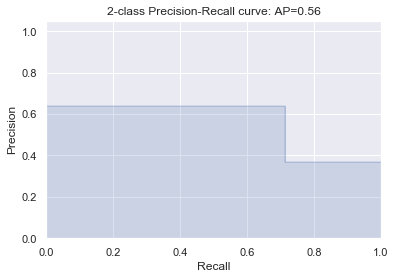

In [60]:
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
print("")

Above 70% recall, the model's precision decreases significantly

### Model with TF-IDF text representation 

Lets evaluate if we can get better performance by using a different word representation: The importance of the word instead of its frequency.

TF-IDF stands for term frequency inverse document frequency. Words are more relevant if they are frequent in a single document, but rare overrall, and are penalized if they are frequent in the whole corpus (e.g "The")


In [61]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', lowercase=True)),
    ('tfidf', TfidfTransformer(use_idf=True, smooth_idf=True)),
    ('clf', MultinomialNB(alpha=1))
])

In [62]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1, class_prior=None, fit_prior=True))],
         verbose=False)

In [63]:
predictions = pipeline.predict(X_test)

In [179]:
print(f'Accuracy score: {accuracy_score(predictions, y_test):.2f}' )
print(f'Precision score: {precision_score(predictions, y_test):.2f}')
print(f'Recall score: {recall_score(predictions, y_test):.2f}')
print(f'F1 score: {f1_score(predictions, y_test):.2f}')

Accuracy score: 0.77
Precision score: 0.63
Recall score: 0.78
F1 score: 0.70


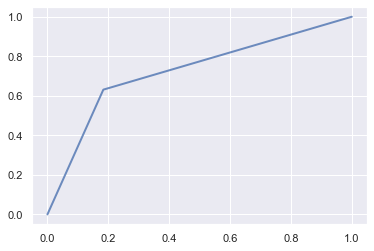

In [65]:
fpr, tpr, thresholds = roc_curve(np.array(y_test), predictions, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f)' % (roc_auc),
         lw=2, alpha=.8)

The ROC curve seems to be slightly worst with a TF-IDF representaion

## Our very own implementation of NB
We'll implement a binary naive bayes because we're dealing with category data with two categories. If we had numeric data we could assume it is normally distributed and implemented a Gaussian naive bayes. The process is very similar
https://pythonmachinelearning.pro/text-classification-tutorial-with-naive-bayes/






In [127]:
class NaiveBayes:
    """Implementation of Naive Bayes for binary classification
    
    pos: refers to positive class (e.g. label = 1, spam)
    neg: refers to negative class (e.g. label = 0, not spam)
    
    """
    def __init__(self):
        self.num_messages = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()
    
    def clean(self, s):
        translator = str.maketrans("", "", string.punctuation)
        return s.translate(translator)

    def tokenize(self, text):
        text = self.clean(text).lower()
        return re.split("\W+", text)

    def get_word_counts(self, words):
        word_counts = Counter()
        for word in words:
            word_counts[word] += 1
        return word_counts
    
    def fit(self, X, Y):

        n = len(X)
        self.num_messages['pos'] = sum(Y)
        self.num_messages['neg'] = len(Y) - self.num_messages['pos']
        self.log_class_priors['pos'] = math.log(self.num_messages['pos'] / n)
        self.log_class_priors['neg'] = math.log(self.num_messages['neg'] / n)
        self.word_counts['pos'] = {}
        self.word_counts['neg'] = {}

        for x, y in zip(X, Y):  # for each document
            c = 'pos' if y == 1 else 'neg'
            counts = self.get_word_counts(self.tokenize(x))
            for word, count in counts.items():  # for each word in the doc
                if word not in self.vocab:
                    self.vocab.add(word)
                if word not in self.word_counts[c]:
                    self.word_counts[c][word] = 0.0

                self.word_counts[c][word] += count
                
    def predict(self, X):
        result = []
        for x in X:
            counts = self.get_word_counts(self.tokenize(x))
            pos_score = 0
            neg_score = 0
            for word, _ in counts.items():
                if word not in self.vocab: continue

                # add Laplace smoothing (add 1 to the word count to handle cases when the word is not present)
                log_w_given_pos = math.log( (self.word_counts['pos'].get(word, 0.0) + 1) / (self.num_messages['pos'] + len(self.vocab)) )
                log_w_given_neg = math.log( (self.word_counts['neg'].get(word, 0.0) + 1) / (self.num_messages['neg'] + len(self.vocab)) )

                pos_score += log_w_given_pos
                neg_score += log_w_given_neg

            pos_score += self.log_class_priors['pos']
            neg_score += self.log_class_priors['neg']

            if pos_score > neg_score:
                result.append(1)
            else:
                result.append(0)
        return result

In [128]:
nb = NaiveBayes()

In [129]:
nb.fit(X_train, y_train)

In [130]:
predictions = nb.predict(X_test)

In [178]:
print(f'Accuracy score: {accuracy_score(predictions, y_test):.2f}' )
print(f'Precision score: {precision_score(predictions, y_test):.2f}')
print(f'Recall score: {recall_score(predictions, y_test):.2f}')
print(f'F1 score: {f1_score(predictions, y_test):.2f}')

Accuracy score: 0.77
Precision score: 0.63
Recall score: 0.78
F1 score: 0.70


### Calculate the metrics on the test set.
Use true label from original [dataset](https://www.figure-eight.com/data-for-everyone/)

In [166]:
original = pd.read_csv("../data/original.csv")

In [167]:
test = pd.read_csv("../data/test.csv")

In [168]:
test_truth = original.iloc[test['id'].to_list(), :] #[['choose_one']]
test_truth['target'] = test_truth.apply(lambda row: int(row['choose_one'] == 'Relevant'), axis=1)

In [169]:
predictions = nb.predict(test["text"])

In [170]:
submission = pd.DataFrame({'id' : test['id'], 'target' : predictions})

In [171]:
submission["actual"] = test_truth['target'].to_list()

In [172]:
predictions = submission['target']
y_test = submission['actual']

In [176]:
print(f'Accuracy score: {accuracy_score(predictions, y_test):.2f}' )
print(f'Precision score: {precision_score(predictions, y_test):.2f}')
print(f'Recall score: {recall_score(predictions, y_test):.2f}')
print(f'F1 score: {f1_score(predictions, y_test):.2f}')

Accuracy score: 0.77
Precision score: 0.63
Recall score: 0.78
F1 score: 0.70


---

### Conclusion

**We obtained the same performance using bag of words or TF-IDF, and using scikit's vs our implementation of NB**

**The performance on the holdout test set is very similar to the validation set**

**These metrics are very close the ones obtained with LSTMs and 1D convolutions and word embeddings**
It may be that we don't have enough data to properly train a LSTM

---